In [57]:

!pip install contractions scikit-learn==1.3.2 nltk spacy wordcloud

!pip install --upgrade pip

In [58]:
import re
import os
import joblib
import nltk
import spacy
import contractions
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM,GRU,Bidirectional
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense,Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [59]:
all_data=pd.read_csv('/kaggle/input/sentiment-analysis-dataset/training.1600000.processed.noemoticon.csv',encoding='ISO-8859-1')
all_data.columns=['target','id','data','quary','user','text']
data=all_data[['target','text']]

In [60]:
data['target'].value_counts()

target
0    799996
4    248576
Name: count, dtype: int64

In [61]:
data = data[['target', 'text']]
data['target'] = data['target'].replace(4, 1)
data.shape

(1048572, 2)

In [62]:
data.isnull().sum()


target    0
text      0
dtype: int64

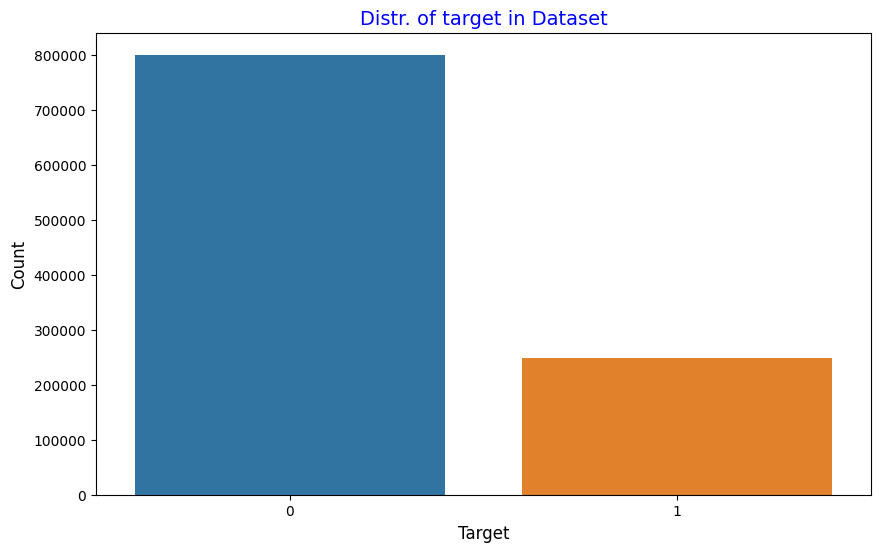

In [63]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='target')
plt.title('Distr. of target in Dataset', fontsize=14, c='b')
plt.xlabel('Target', c='k', fontsize=12)
plt.ylabel('Count', c='k', fontsize=12)
plt.show()

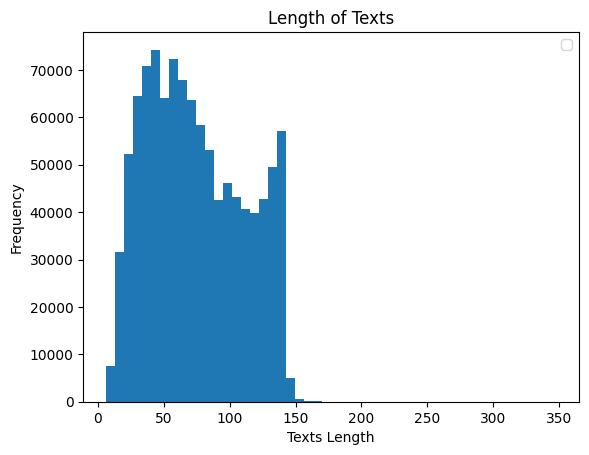

In [64]:
length_train = data['text'].str.len()
plt.hist(length_train, bins=50)
plt.legend()
plt.title('Length of Texts')
plt.xlabel('Texts Length')
plt.ylabel('Frequency')
plt.show()

In [65]:
from sklearn.utils import resample

majority = data[data['target'] == 0]
minority = data[data['target'] == 1]

minority_upsampled = resample(minority,
                              replace=True,
                              n_samples=len(majority),
                              random_state=42)

balanced_data = pd.concat([majority, minority_upsampled])
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)


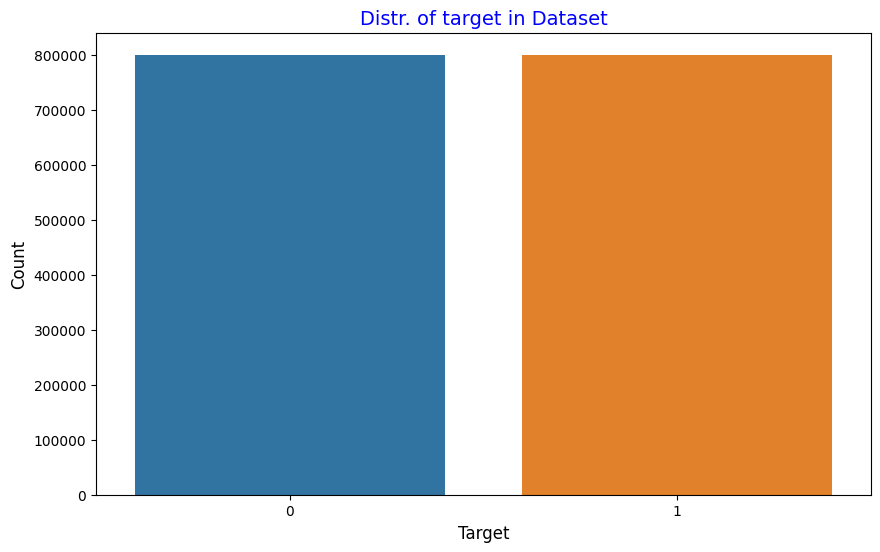

In [66]:
plt.figure(figsize=(10, 6))
sns.countplot(data=balanced_data, x='target')
plt.title('Distr. of target in Dataset', fontsize=14, c='b')
plt.xlabel('Target', c='k', fontsize=12)
plt.ylabel('Count', c='k', fontsize=12)
plt.show()

In [67]:

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
emoticon_meanings = {
    ":)": "Happy",
    ":(": "Sad",
    ":D": "Very Happy",
    ":|": "Neutral",
    ":O": "Surprised",
    "<3": "Love",
    ";)": "Wink",
    ":P": "Playful",
    ":/": "Confused",
    ":*": "Kiss",
    ":')": "Touched",
    "XD": "Laughing",
    ":3": "Cute",
    ">:(": "Angry",
    ":-O": "Shocked",
    ":|]": "Robot",
    ":>": "Sly",
    "^_^": "Happy",
    "O_o": "Confused",
    ":-|": "Straight Face",
    ":X": "Silent",
    "B-)": "Cool",
    "<(‘.'<)": "Dance",
    "(-_-)": "Bored",
    "(>_<)": "Upset",
    "(¬‿¬)": "Sarcastic",
    "(o_o)": "Surprised",
    "(o.O)": "Shocked",
    ":0": "Shocked",
    ":*(": "Crying",
    ":v": "Pac-Man",
    "(^_^)v": "Double Victory",
    ":-D": "Big Grin",
    ":-*": "Blowing a Kiss",
    ":^)": "Nosey",
    ":-((": "Very Sad",
    ":-(": "Frowning",
}

def remove_repeated_characters(text, max_repeats=2):
    """Remove repeated characters, e.g., 'loooove' becomes 'love'."""
    pattern = r"(.)\1{%d,}" % (max_repeats - 1)
    return re.sub(pattern, r"\1", text)

def remove_mentions(text):
    """Remove mentions (e.g., @user) from the text."""
    return re.sub(r"@[\w]*", '', text)

def remove_links(text):
    """Remove URLs from the text."""
    return re.sub(r"https?://\S+|www\.\S+", '', text)


def convert_emoticons(text: str):
    ''' This Function is to replace the emoticons with thier meaning instead '''
    for emoticon, meaning in emoticon_meanings.items():
         text = text.replace(emoticon, '' + meaning + '')
    return text

def remove_punctuations(text):
    """Remove punctuation and non-alphabetic characters, except for apostrophes."""
    return re.sub(r"[^a-zA-Z\s']", '', text)

def tokenize_and_lemmatize(text):
    """Tokenize and lemmatize the text."""
    tokenized_text = word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(word) for word in tokenized_text])


def clean_text(text):
    """
    Apply all text preprocessing steps in order.
    """
    text = text.lower().strip()
    text = remove_links(text)
    text = remove_mentions(text)
    text = remove_repeated_characters(text)
    text = convert_emoticons(text)
    text = remove_punctuations(text)
    text = tokenize_and_lemmatize(text)
    text = text.lower()
    text = ' '.join(text.split())  # remove redundant spaces
    return text


In [68]:


tqdm.pandas()
balanced_data['clean_text'] = balanced_data['text'].progress_apply(clean_text)

100%|██████████| 1599992/1599992 [03:30<00:00, 7597.86it/s]


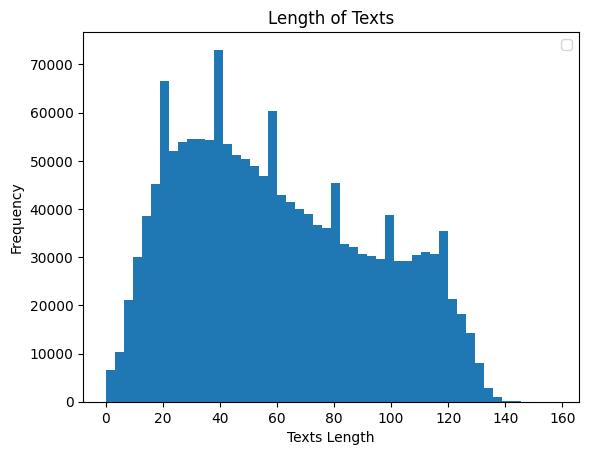

In [69]:
length_train = balanced_data['clean_text'].str.len()
plt.hist(length_train, bins=50)
plt.legend()
plt.title('Length of Texts')
plt.xlabel('Texts Length')
plt.ylabel('Frequency')
plt.show()

In [70]:
balanced_data.shape

(1599992, 3)

In [71]:
tokenizer = Tokenizer(num_words=50000, oov_token="<OOV>")
tokenizer.fit_on_texts(balanced_data['clean_text'])

In [72]:
sequences = tokenizer.texts_to_sequences(balanced_data['clean_text'])


In [73]:
max_len = max(len(seq) for seq in sequences)
max_len

40

In [74]:
padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

In [75]:
X = padded
y = balanced_data['target'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [76]:
def plot_history(history, model_name):
    # Accuracy
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()



In [77]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, X_val, y_val, name):
    y_pred = (model.predict(X_val) > 0.5).astype(int).reshape(-1)
    acc = accuracy_score(y_val, y_pred)
    print(f"{name} Validation Accuracy: {acc:.4f}")
    cm = confusion_matrix(y_val, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f'{name} Confusion Matrix')
    plt.show()



In [78]:

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]


In [79]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

In [80]:
model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=50000, output_dim=64, input_length=max_len))
model_rnn.add(SimpleRNN(64))
#model_rnn.add(Dropout(0.1))
model_rnn.add(Dense(16,activation='relu'))
model_rnn.add(Dropout(0.5))
model_rnn.add(Dense(1, activation='sigmoid'))
optimizer = Adam(learning_rate=1e-5)
model_rnn.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [81]:
history_rnn = model_rnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=1024,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.5272 - loss: 0.6895 - val_accuracy: 0.7315 - val_loss: 0.5581
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.7440 - loss: 0.5545 - val_accuracy: 0.7757 - val_loss: 0.4863
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.7798 - loss: 0.4998 - val_accuracy: 0.7911 - val_loss: 0.4581
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.7963 - loss: 0.4746 - val_accuracy: 0.7997 - val_loss: 0.4457
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8036 - loss: 0.4602 - val_accuracy: 0.8024 - val_loss: 0.4366
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8080 - loss: 0.4501 - val_accuracy: 0.8061 - val_loss: 0.4294
Epoch 7/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8122 - loss: 0.4422 - val_accuracy: 0.8086 - val_loss: 0.4249
Epoch 8/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8156 -

In [82]:
print(model_rnn.summary())

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 40, 64)         │     3,200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,627,941 (36.73 MB)

 Trainable params: 3,209,313 (12.24 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,418,628 (24.49 MB)

None


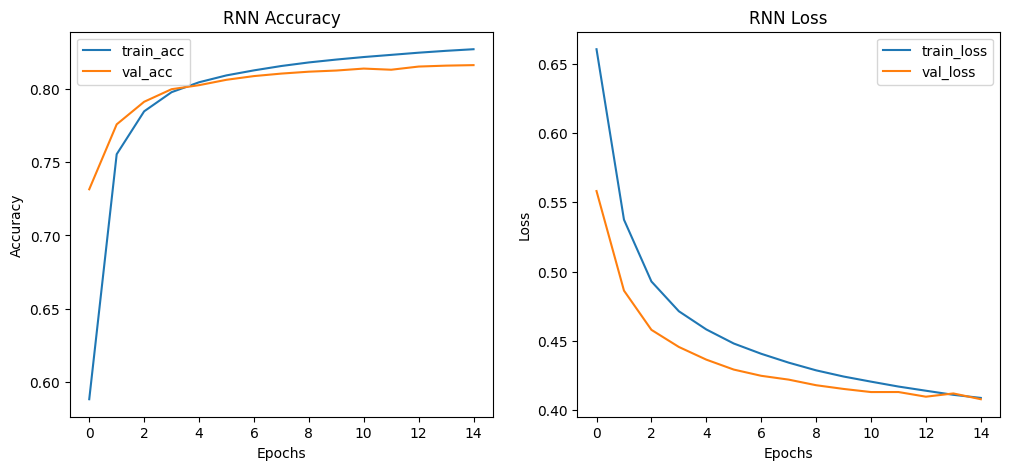

In [83]:
plot_history(history_rnn, 'RNN')

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step
RNN Validation Accuracy: 0.8161


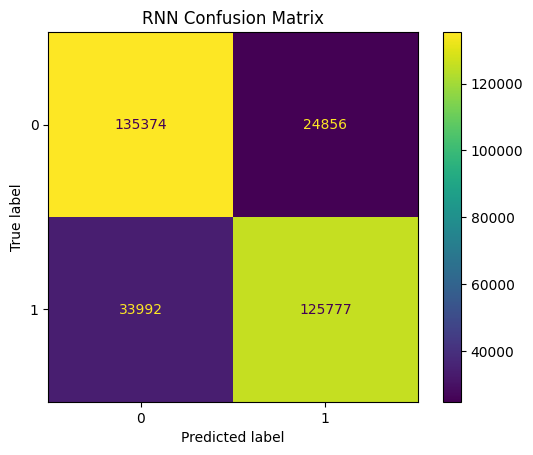

In [84]:
evaluate_model(model_rnn, X_val, y_val, 'RNN')

In [85]:
model_gru = Sequential()
model_gru.add(Embedding(input_dim=50000, output_dim=64, input_length=max_len))
model_gru.add(Bidirectional(GRU(64)))
#model_gru.add(Dropout(0.5)) 
model_gru.add(Dense(16, activation='relu'))
model_gru.add(Dropout(0.5)) 
model_gru.add(Dense(1, activation='sigmoid'))
optimizer = Adam(learning_rate=1e-5)
model_gru.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [86]:
history_gru = model_gru.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=2048,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 47ms/step - accuracy: 0.5273 - loss: 0.6917 - val_accuracy: 0.6064 - val_loss: 0.6829
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.6002 - loss: 0.6772 - val_accuracy: 0.6683 - val_loss: 0.6442
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.6703 - loss: 0.6260 - val_accuracy: 0.7538 - val_loss: 0.5366
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.7465 - loss: 0.5445 - val_accuracy: 0.7729 - val_loss: 0.5021
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.7660 - loss: 0.5197 - val_accuracy: 0.7854 - val_loss: 0.4849
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.7768 - loss: 0.5063 - val_accuracy: 0.7906 - val_loss: 0.4742
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.7841 - loss: 0.4949 - val_accuracy: 0.7956 - val_loss: 0.4670
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.7891 - loss: 0.4882 - 

In [87]:
print(model_gru.summary())

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 40, 64)         │     3,200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 128)            │        49,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,756,005 (37.22 MB)

 Trainable params: 3,252,001 (12.41 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,504,004 (24.81 MB)

None


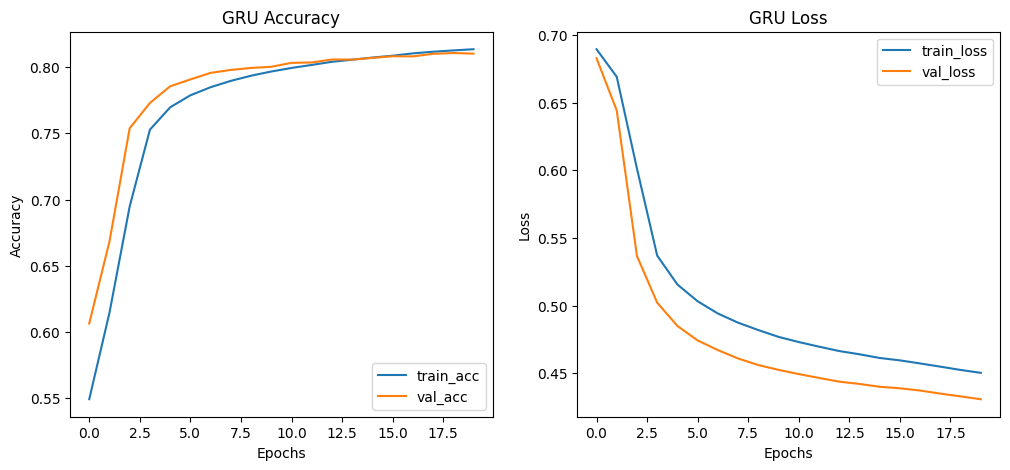

In [88]:
plot_history(history_gru, 'GRU')

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step
GRU Validation Accuracy: 0.8101


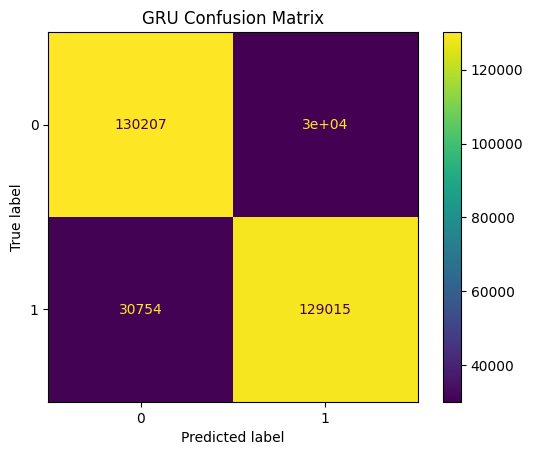

In [89]:
evaluate_model(model_gru, X_val, y_val, 'GRU')

In [90]:


model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=50000, output_dim=64, input_length=max_len))
model_lstm.add(Bidirectional(LSTM(64)))
model_lstm.add(Dropout(0.3)) 
model_lstm.add(Dense(16, activation='relu'))
model_lstm.add(Dropout(0.5)) 
model_lstm.add(Dense(1, activation='sigmoid'))
optimizer = Adam(learning_rate=3e-5)
model_lstm.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [91]:
history_lstm = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=1024,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - accuracy: 0.5951 - loss: 0.6636 - val_accuracy: 0.7714 - val_loss: 0.5217
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.7613 - loss: 0.5245 - val_accuracy: 0.7945 - val_loss: 0.4465
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.7963 - loss: 0.4639 - val_accuracy: 0.8036 - val_loss: 0.4284
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.8071 - loss: 0.4436 - val_accuracy: 0.8082 - val_loss: 0.4192
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.8135 - loss: 0.4309 - val_accuracy: 0.8134 - val_loss: 0.4112
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.8180 - loss: 0.4221 - val_accuracy: 0.8157 - val_loss: 0.4059
Epoch 7/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.8205 - loss: 0.4154 - val_accuracy: 0.8153 - val_loss: 0.4039
Epoch 8/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.8239 -

In [92]:
print(model_lstm.summary())

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 40, 64)         │     3,200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,804,389 (37.40 MB)

 Trainable params: 3,268,129 (12.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,536,260 (24.93 MB)

None


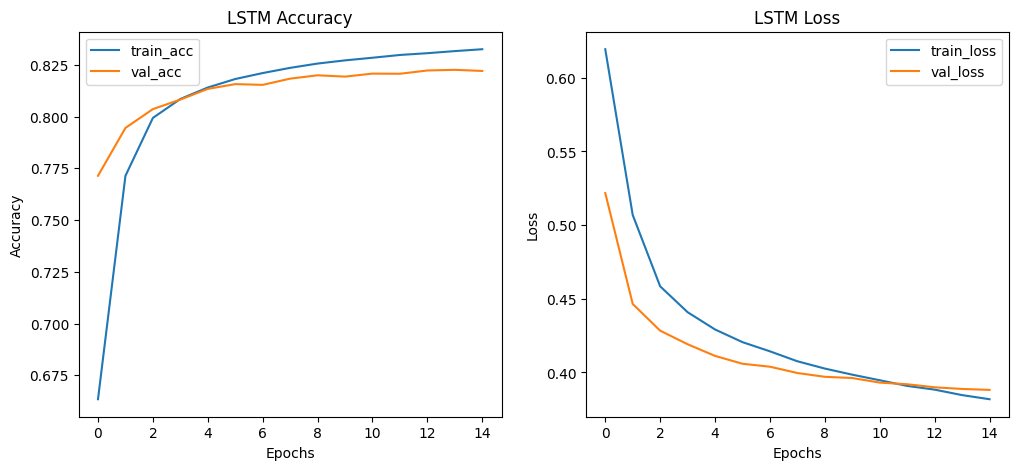

In [93]:
plot_history(history_lstm, 'LSTM')

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step
LSTM Validation Accuracy: 0.8220


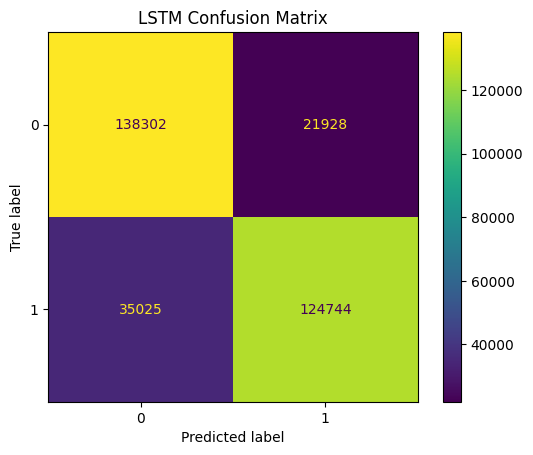

In [94]:
evaluate_model(model_lstm, X_val, y_val, 'LSTM')

In [95]:
model_rnn.save('rnn_model.h5')
model_lstm.save('lstm_model.h5')
model_gru.save('gru_model.h5')